# Text to images with Stable Diffusion 2.1

*The model used in this demo is licensed with a [CreativeML OpenRAIL++ license](https://huggingface.co/stabilityai/stable-diffusion-2/blob/main/LICENSE-MODEL). The authors of the model claim no rights on the outputs you generate, you are free to use them and are accountable for their use which must not go against the provisions set in this license. The license forbids you from sharing any content that violates any laws, produce any harm to a person, disseminate any personal information that would be meant for harm, spread misinformation and target vulnerable groups. For the full list of restrictions please read the license.*

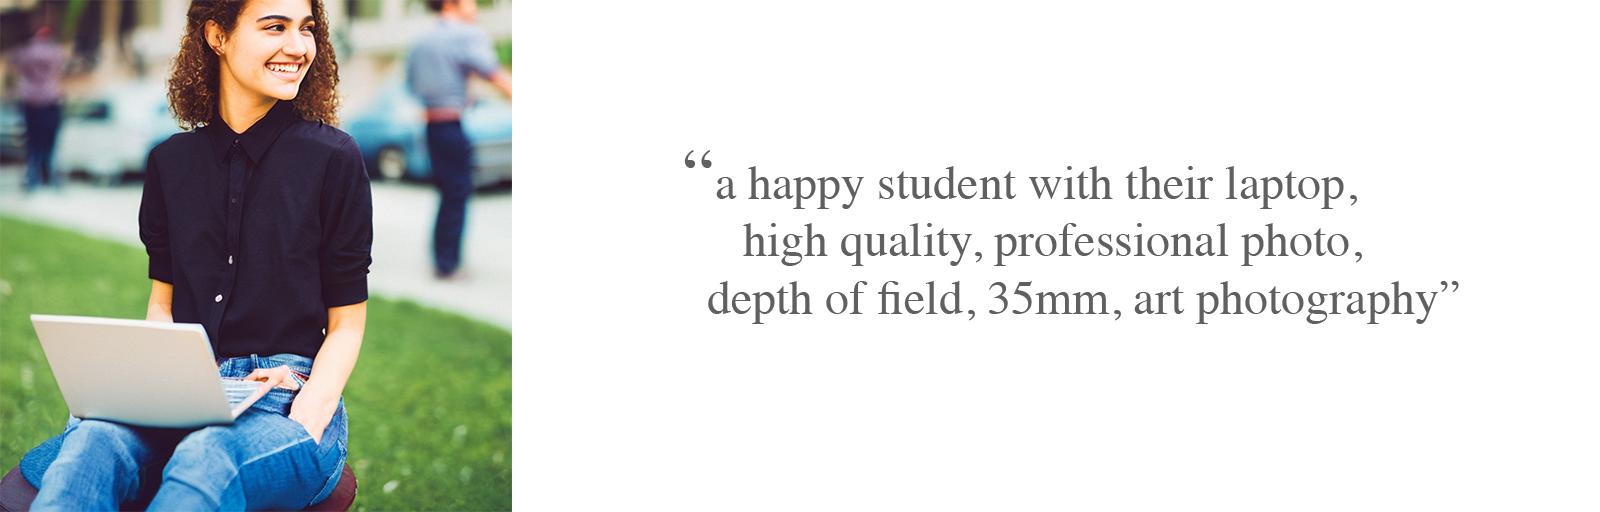

## Introduction
Stable Diffusion stems from a class of deep generative models called diffusion models which can generate images from random numbers (noise). To guide the image generation procedure, we can condition the model on some class label, e.g., 'cat', or a text description to generate images that should include things what we request. Stable Diffusion gets guidance from text prompts where it is up to the user to come up with clever prompts to obtain images with the correct content and desired style.    

In this exercise, we will generate images from written text prompts with a pre-trained Stable Diffusion 2.1 model. We have implmented the following tasks for you to play around with:
1. Generate your (potentially) first image with Stable Diffusion
2. Generate images using different number of inference steps
3. Generate images with varying prompts 
4. Generate images with negative prompts
5. Generate image with a text prompt and an initial image using the image-to-image version of Stable Diffusion

We have provided some example text prompts for each task. **Feel free to write your own text prompts to generate images.**

Stable Diffusion 2.1 was trained on the [LAION-5B dataset](https://laion.ai/blog/laion-5b/) filtered using LAION's NSFZ Detector to remove images with inappropriate content. Furthermore, they use hundreds of GPUs to train the model, which is one of the main reasons why we will use a pre-trained model to generate images.    

**Be aware of that the image generation typically takes up to 30 seconds even though you use a GPU**

(Optional) For further reading about Stable Diffusion:
* Blog post on how to run Stable Diffusion and an overview of the model components: [https://huggingface.co/blog/stable_diffusion](https://huggingface.co/blog/stable_diffusion)
* Guide on prompt engineering with Stable Diffusion and GPU memory optimization: [https://huggingface.co/docs/diffusers/stable_diffusion](https://huggingface.co/docs/diffusers/stable_diffusion)
* Blog post on Stable Diffusion with visualizations and without math: [https://jalammar.github.io/illustrated-stable-diffusion/](https://jalammar.github.io/illustrated-stable-diffusion/)
* Original paper by Rombach et al. published at CVPR 2022: https://arxiv.org/abs/2112.10752

## Getting started
You first need to set up the environment and install some additional Python packages into it. Run the cells below by clcking on the play symbol on left side of the cell or by activating the cell and pressing SHIFT+ENTER on your keyboard.

First, please make sure you are using a GPU runtime to run this notebook, so inference is much faster. If the following command fails, use the `Runtime` menu above and select `Change runtime type`.

In [1]:
!nvidia-smi

Mon Mar 20 15:20:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    30W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Installing the packages should take **a minute or so**.

In [2]:
!pip install diffusers==0.11.1 transformers accelerate scipy safetensors
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import helper functions
We have placed most of the Python code into functions in the file `helpers.py` that executes the calls to Stable Diffusion for generating images, loading models and input images, and visualizing the generated images.

Run the cell below to import the needed helper functions. Feel free to take a look in `helpers.py` if you are interested. 

In [3]:
## Import helper functions to generate images, load models, and printing plots of the generated images.
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline 
from diffusers import EulerDiscreteScheduler, DPMSolverMultistepScheduler, DDIMScheduler

from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

device = "cuda" if torch.cuda.is_available() else "cpu"

def generate_image_from_text_prompt(pipe, prompt, negative_prompt="", num_inference_steps=25, seed=42):
    generator = torch.Generator(device).manual_seed(seed)
    images = pipe(prompt=prompt,
                  negative_prompt=negative_prompt,
                  num_inference_steps=num_inference_steps, 
                  generator=generator).images
    if len(images) == 1:
        return images[0]
    return images

def generate_image_from_text_prompt_and_initial_image(pipe, init_image, prompt, negative_prompt="", 
                                                      strength=0.8, guidance_scale=7.5,
                                                      num_inference_steps=50, seed=42):
    generator = torch.Generator(device).manual_seed(seed)
    images = pipe(image=init_image, 
                  prompt=prompt,
                  negative_prompt=negative_prompt,
                  strength=strength,
                  guidance_scale=guidance_scale,
                  num_inference_steps=num_inference_steps, 
                  generator=generator).images
    if len(images) == 1:
        return images[0]
    return images

def plot_images_and_inference_steps(images, inference_steps, rows=2, cols=2):
    fig = plt.figure(figsize=(16., 16.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),  # creates 2x2 grid of axes
                     axes_pad=0.5,  # pad between axes in inch.
                     )
    for ax, im, steps in zip(grid, images, inference_steps):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_title("{:d} steps".format(steps), size=20)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

def plot_images_with_different_prompts(images, base_prompt, additional_prompts, rows=2, cols=2):
    fig = plt.figure(figsize=(16., 16.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),  # creates 2x2 grid of axes
                     axes_pad=0.5,  # pad between axes in inch.
                     )
    print("Base prompt: {:s}".format(base_prompt))
    for ax, im, additional_prompt in zip(grid, images, additional_prompts):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_title("Additional prompt: \n{:s}".format(additional_prompt), size=14)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()
    
def plot_images_with_negative_prompts(images, prompt, negative_prompts, rows=2, cols=2):
    fig = plt.figure(figsize=(16., 16.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),  # creates 2x2 grid of axes
                     axes_pad=0.5,  # pad between axes in inch.
                     )
    print("Prompt: {:s}".format(prompt))
    for ax, im, negative_prompt in zip(grid, images, negative_prompts):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_title("Negative Prompt:\n {:s}".format(negative_prompt), size=14)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

def plot_image_to_image_result_side_by_side(init_image, gen_image, prompt, negative_prompt):
    fig = plt.figure(figsize=(16., 16.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(1, 2),  # creates 2x2 grid of axes
                     axes_pad=0.5,  # pad between axes in inch.
                     )
    print("Prompt: {:s}".format(prompt))
    print("Negative prompt: {:s}".format(negative_prompt))
    for ax, im, title in zip(grid, [init_image, gen_image], ["initial", "generated"]):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_title(title, size=20)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()
    
def load_txt2img_model(model_id='./stable-diffusion-2-base', noise_scheduler='dpm'):
    # Load noise scheduler
    if noise_scheduler == 'dpm':
        scheduler = DPMSolverMultistepScheduler.from_pretrained(model_id, subfolder="scheduler")
    elif noise_scheduler == 'ddim':
        scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")
    elif noise_scheduler == 'euler':
        scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
    # Load Stable Diffusion model
    pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)
    pipe = pipe.to(device)
    print("model loaded")
    return pipe
    
def load_img2img_model(model_id='./stable-diffusion-2-base', noise_scheduler='dpm'):
    # Load noise scheduler'
    if noise_scheduler == 'dpm':
        scheduler = DPMSolverMultistepScheduler.from_pretrained(model_id, subfolder="scheduler")
    elif noise_scheduler == 'ddim':
        scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")
    elif noise_scheduler == 'euler':
        scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
    # Load Stable Diffusion image-to-image model
    pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)
    pipe = pipe.to(device)
    print("model loaded")
    return pipe

def save_model_locally(pipe, path='./stable-diffusion-2-base'):
    # Execute the command below to save the pretrained Stable Diffusion model. 
    # This is to avoid downloading the model over and over again.
    #
    pipe.save_pretrained(path)
    print("Pretrained model saved in path: {:s}".format(path))
    
def load_image(filename, height=768, width=768, mode="RGB"):
    # Get image
    image = Image.open(filename).convert(mode)
    # Resize image
    image = image.resize((height, width))
    return image


## Loading the Stable Diffusion model

The trained Stable Diffusion model is hosted on [Hugging Face](https://huggingface.co/spaces/stabilityai/stable-diffusion). 

Running the cell below will set up things and download the trained model by setting `model_id = "stabilityai/stable-diffusion-2-1"` in the cell. **This should take some minutes.**

The Stable Diffusion model will be defined in the object named `pipe` after running the cell with the appropriate `model_id`.  

In [4]:
# Download the pretrained model 
model_id = "stabilityai/stable-diffusion-2-1"
pipe = load_txt2img_model(model_id)

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model loaded


## Set the random seed
The `seed` below specifies how to initialize the random number generator in the model. In addition to the text, Stable Diffusion is initialized with a fixed amount of "random" numbers, where the seed determines how these numbers should be drawn randomly. Setting the seed is a helpful tool when debugging machine learning models and algorithms.

Run the cell below to set the seed. **Feel free to set the seed to any non-negative number you wish.**

**Note: You will generate different images for different seeds.**

In [5]:
# Set random seed
seed = 42

## Task 1: Generate image with Stable Diffusion from text input 

Now you can generate images by inputting text of your choice to the Stable Diffusion model. 

The `prompt` below specifies the input and running the cell will pass it to the model and finally display the generated content.

**Note** that the time to generate an image varies depending on the hardware that you have access to.

Generating this image should take **less than one minute** on a GPU. 

  0%|          | 0/25 [00:00<?, ?it/s]

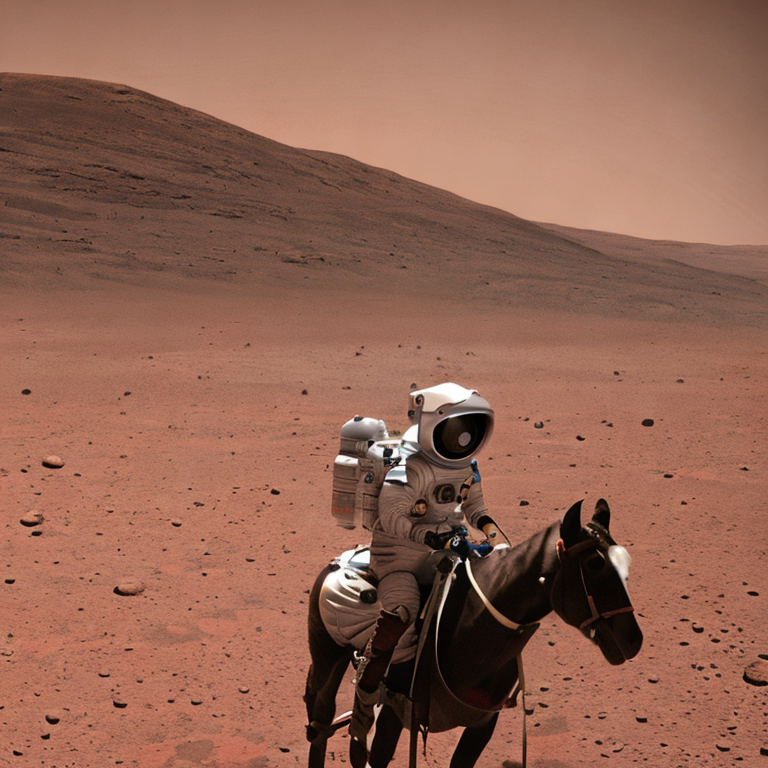

In [6]:
# The prompt is the text you input to the model, edit below
prompt = "a photo of an astronaut riding a horse on mars"

# Run Stabe Diffusion with the provided input
image = generate_image_from_text_prompt(pipe, prompt, seed=seed)

# Display image within cell 
image

# ... or save the output as a PNG   
#image.save("astronaut_rides_horse.png")

## Task 2: Images from different inference steps
We can inspect what the generated images look like at different number of inference steps. An inference step involves a forward pass of the the text prompt and the current image passed as input to Stable Diffusion. The first inference step involves inputting an image with random pixels together with the written text prompt to obtain the generated image. The subsequent inference steps then uses the last generated image as input together with the text prompt to refine the generated image. 


Given a text prompt, we will generate images at different inference steps and inspect the resulting output images by running the cell below. 

**Be patient. Generating these images will probably take a few minutes.**

In [7]:
# The prompt is the text you input to the model, edit below
prompt = "a photo of an astronaut riding a horse on mars"

# The different number of inference steps to test
inference_steps = [1, 2, 4, 8, 16, 25]

images = []
for num_inference_steps in inference_steps:
    # Generate image from the prompt for the given number of inference steps
    image = generate_image_from_text_prompt(pipe, prompt, 
                                            num_inference_steps=num_inference_steps,
                                            seed=seed)
    images.append(image)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Plot the generated images to inspect what they look like at different inference steps by running the cell below. 

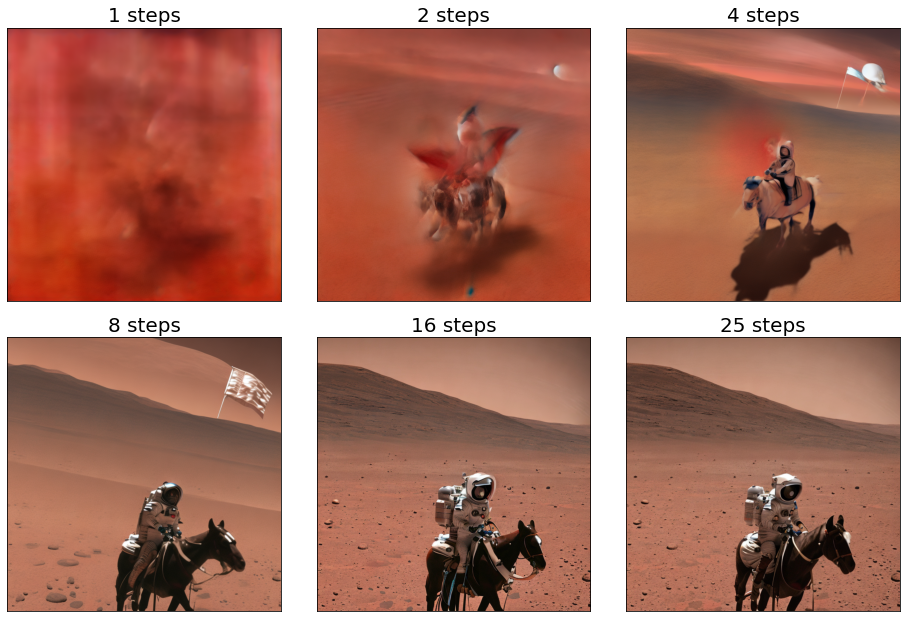

In [8]:
plot_images_and_inference_steps(images, inference_steps, rows=2, cols=3)

## Task 3: Changing the text prompt
We can add more descriptions for the image in the text prompt to further instruct Stable Diffusion on what type of generated image we want. 

In this task, we begin with a base text prompt and then extend the text prompt with different additional text prompts. We have provided four different additional prompts to try out. 

Feel free to change the `base_prompt` and `additional_prompts`. Place the additional prompts within quotation marks `"..."`. You may also separate words with commas like `"high quality, cartoon"`, which may help the model to recognize the given text prompt better. 

In [9]:
# A base prompt with text that is the same for all generated images 
base_prompt = "a photo of an astronaut riding a horse on mars" # e.g. "a photo of a man reading a book"

# Additional prompts to complement the base prompt
additional_prompts = ["blender",
                      "blender, in the style of <midjourney>",
                      "drawn by hand",
                      "drawn by hand, in the style of <midjourney>"]

Run the cell below to start generating images with the different text prompts.

In [10]:
images = []
for additional_prompt in additional_prompts:
    # Extend the base prompt with the additional prompt 
    prompt = base_prompt + ', ' + additional_prompt
    # Generate image from the base + additional prompt
    image = generate_image_from_text_prompt(pipe, 
                                            prompt=prompt, 
                                            seed=seed)
    images.append(image)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Plot the generated images to inspect what how they differ given the different additional prompts by running the cell below.

Base prompt: a photo of an astronaut riding a horse on mars


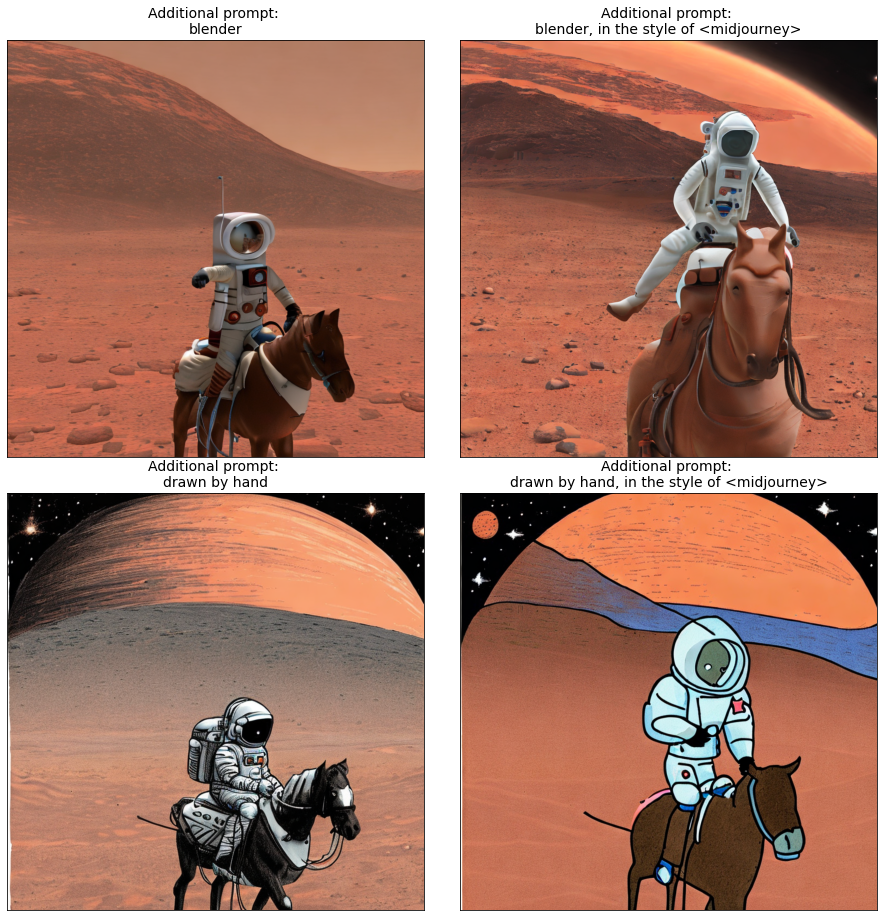

In [11]:
plot_images_with_different_prompts(images, base_prompt, additional_prompts, rows=2, cols=2)

## Task 4: Add a negative prompt as input
Stable Diffusion can use negative prompts to instruct the model of what it should *not* include in the generated images. 

In this task, we provide a text prompt to the model to instruct what type of images we want as well as a negative prompt where we tell the model what we want it to avoid generating. We have provided four different negative prompts to try out.

Feel free to change the `prompt` and `negative_prompts`. Place the negative prompts within quotation marks "...". Adding several words separated by commas "bad quality, cartoon" may help the model to recognize the given negative text prompt better.

In [12]:
# Prompt to input to the model, edit below
prompt = "a painting of a vase with roses on a table next with an open book, oil on canvas, fine art, artistic style"

# Negative prompts for instructing the model what it should not include in the generated images
negative_prompts = ["",
                    "in the style of <wrong>",
                    "red",
                    "red, in the style of <wrong>"]

Run the cell below to start generating images with the different negative prompts.

In [13]:
images = []
for negative_prompt in negative_prompts:
    # Generate image from the prompt and the negative prompt
    image = generate_image_from_text_prompt(pipe, 
                                            prompt=prompt, 
                                            negative_prompt=negative_prompt,
                                            num_inference_steps=num_inference_steps,
                                            seed=seed)
    images.append(image)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Plot the generated images to inspect what how they differ given the different negative prompts by running the cell below.

Prompt: a painting of a vase with roses on a table next with an open book, oil on canvas, fine art, artistic style


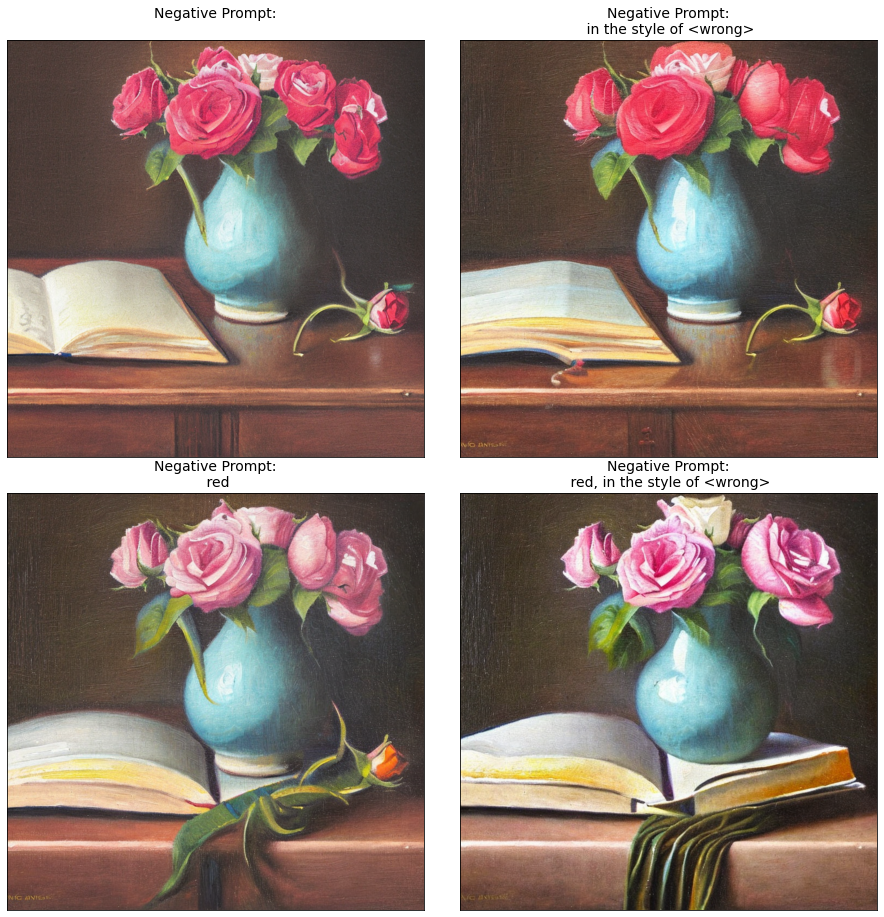

In [14]:
plot_images_with_negative_prompts(images, prompt, negative_prompts, rows=2, cols=2)

## Task 5: Image-to-image Generation
Stable Diffusion can generate images from a rough image sketches and text prompts. This is called image-to-image generation, where Stable Diffusion will refine an image template by filling it in with the infomration from the text prompt.  

In this example, our initial image will be a rough sketch made by the course personnel of the Aalto University logo on a green landscape with a river. 

### Release memory 
Since the Stable Diffusion model is quite large (5GB), the notebook could crash if you load another model without releasing the memory of the first model due to the low memory limit we may have have access to. 

Run the following command that deletes the first model in `pipe` to release its memory before loading the image-to-image generation model.

In [15]:
# Release memory of previous model before loading image-to-image model
del pipe

### Import helper functions and load model

In [16]:
# Load image-to-image Stable Diffusion model with the same model_id as above
pipe = load_img2img_model(model_id)

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model loaded


### Load initial image sketch

Run the cell below to load and display the image that we will refine using a text prompt and Stable Diffusion.

--2023-03-20 15:25:54--  https://raw.githubusercontent.com/asolin/notebooks/main/notebooks/images/img2img-aalto-input.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 343949 (336K) [image/png]
Saving to: ‘img2img-aalto-input.png.2’

img2img-aalto-input 100%[===================>] 335.89K  --.-KB/s    in 0.03s   

2023-03-20 15:25:54 (10.3 MB/s) - ‘img2img-aalto-input.png.2’ saved [343949/343949]



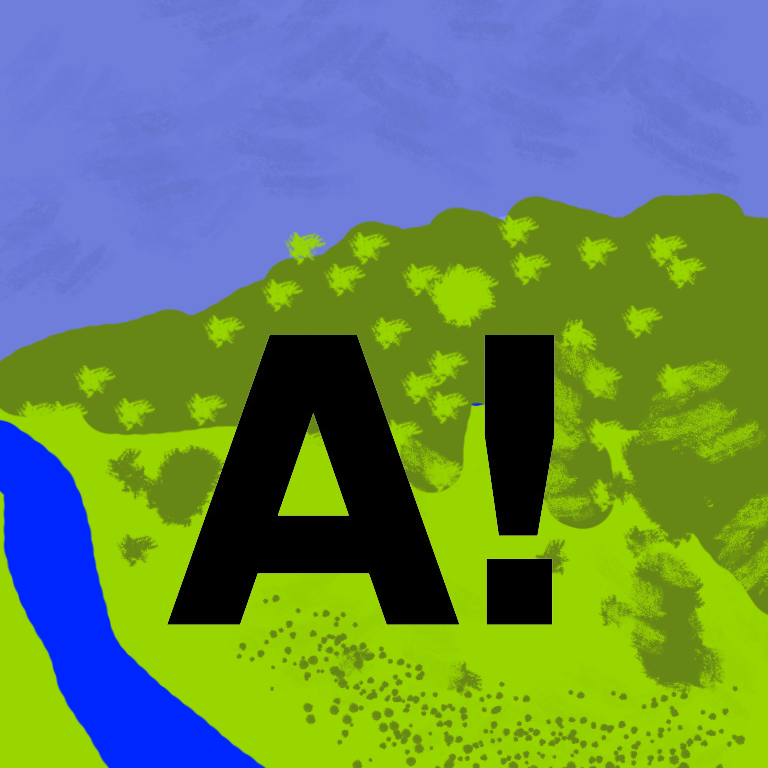

In [17]:
# Download and load the image drawn by the course personnel
!wget https://raw.githubusercontent.com/asolin/notebooks/main/notebooks/images/img2img-aalto-input.png
init_image = load_image('/content/img2img-aalto-input.png')
# Display image
init_image

Run the cell below to set the `prompt` and `negative_prompt` of what the refined image should look like. 

**Feel free to change the prompts.**

In [18]:
# Prompt to give as input to the model together with the initial image
prompt = "A fantasy landscape with a giant sculpture of the capital letter A and an exclamation mark in the middle, fresh, fantasy photograph, realistic, depth of field"

# Negative prompts for model to avoid generating in the image
negative_prompt = "in the style of <wrong>, watermark, green" # e.g. "blender, cropped, lowres, out of frame, blurry, bad art, blurred, watermark, clipart"

Run the cell below to generate the image from the given prompts and initial sketch image. 

Feel free to play around with the hyperparameters `strength` and `guidance_scale` to tune the resulting output images. The `strength` (0-1) indicates how much the initial image should be transformed. The `guidance_scale` (>1) indicates how closely linked the generated images should be to the text prompt. 

  0%|          | 0/40 [00:00<?, ?it/s]

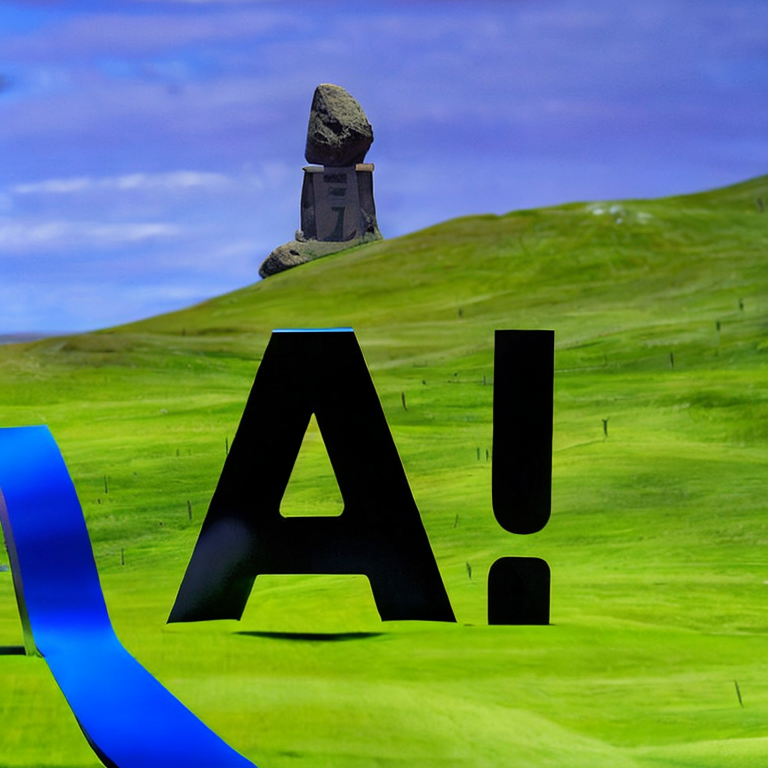

In [19]:
# Hyperparameters
strength = 0.8 # how much should the initial image be changed
guidance_scale = 7.5 # how linked are generated image to prompt

# Generate and display image
image = generate_image_from_text_prompt_and_initial_image(pipe, 
                                                          init_image=init_image, 
                                                          prompt=prompt, 
                                                          negative_prompt=negative_prompt, 
                                                          strength=strength, 
                                                          guidance_scale=guidance_scale,
                                                          seed=seed) 
image